# Activity Classification - DNN1 Training

This notebook trains our first Deep Neural Network on the physical activity dataset.


## Load Data and Prepare Training Set

In [1]:
%reset -f

import importlib
import sys, os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
import activity_functions
importlib.reload(activity_functions)
from activity_functions import *

In [2]:
activtity = load_data()

Loaded from Kaggle: /home/thuy/.cache/kagglehub/datasets/diegosilvadefrana/fisical-activity-dataset/versions/4/dataset2.csv


In [3]:
df_train, df_test = create_train_test(activtity, test_ratio=0.2)

In [4]:
X_train, y_train, X_test, y_test = prepare_for_train(df_train, df_test)

In [5]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

## Hyperband + Regularization

In [6]:
tuner = kt.Hyperband(
    build_model_dnn,
    objective="val_accuracy",
    max_epochs=50,
    factor=3,
    directory="dnn1",
    project_name="hyperband_tuning"
)

tuner.search(
    X_train,
    y_train_encoded,
    validation_split=0.2,
    epochs=50,
    batch_size=1024,
    verbose=1
)

Trial 90 Complete [00h 51m 12s]
val_accuracy: 0.4857817590236664

Best val_accuracy So Far: 0.9887550473213196
Total elapsed time: 1d 04h 27m 43s


In [7]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for hp_name in best_hps.values.keys():
    print(f"  {hp_name}: {best_hps.get(hp_name)}")

Best hyperparameters:
  learning_rate: 0.0001855349762763219
  optimizer: adam
  dropout: 0.1
  weight_decay: 0.001
  n_hidden: 8
  units: 256
  tuner/epochs: 50
  tuner/initial_epoch: 17
  tuner/bracket: 2
  tuner/round: 2
  tuner/trial_id: 0067


## Fit Best Model

In [8]:
best_model = tuner.hypermodel.build(best_hps)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=7,
    restore_best_weights=True
)

history = best_model.fit(
    X_train,
    y_train_encoded,
    validation_split=0.2,
    epochs=50,
    batch_size=1024,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 161s 88ms/step - accuracy: 0.8177 - loss: 1.3654 - val_accuracy: 0.9171 - val_loss: 0.6917
Epoch 2/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 148s 83ms/step - accuracy: 0.9079 - loss: 0.6037 - val_accuracy: 0.9433 - val_loss: 0.4263
Epoch 3/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 187s 75ms/step - accuracy: 0.9270 - loss: 0.4403 - val_accuracy: 0.9538 - val_loss: 0.3412
Epoch 4/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 122s 68ms/step - accuracy: 0.9391 - loss: 0.3726 - val_accuracy: 0.9625 - val_loss: 0.2936
Epoch 5/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 161s 79ms/step - accuracy: 0.9466 - loss: 0.3340 - val_accuracy: 0.9662 - val_loss: 0.2700
Epoch 6/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 148s 82ms/step - accuracy: 0.9518 - loss: 0.3085 - val_accuracy: 0.9679 - val_loss: 0.2566
Epoch 7/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 208s 86ms/step - accuracy: 0.9554 - loss: 0.2894 - val_accuracy: 0.9731 - val_loss: 0.2364
Epoch 8/50
1791/1791 ━━━━━━━━━━━━━━━━━━━━ 217s 95ms/step - accuracy: 

#### Accuracy Plot

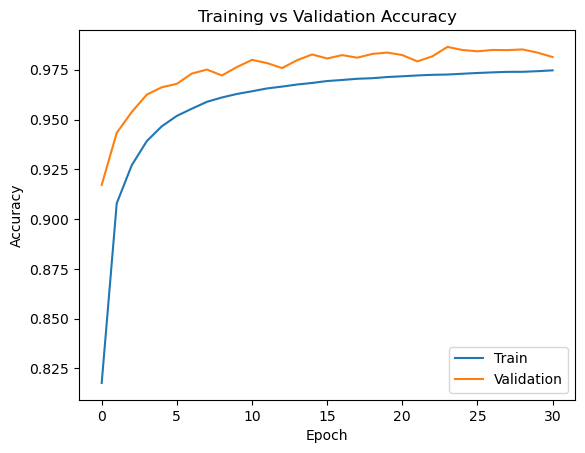

In [9]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(["Train", "Validation"])
plt.show()

#### Loss Plot

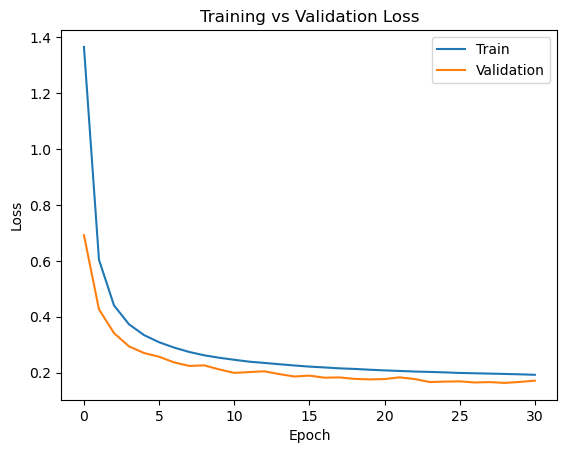

In [10]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(["Train", "Validation"])
plt.show()

## Model Evaluation

In [11]:
y_test_hat = best_model.predict(X_test)
y_test_pred = np.argmax(y_test_hat, axis=1)
compute_scores(y_test_encoded, y_test_pred, verbose=True)

17901/17901 ━━━━━━━━━━━━━━━━━━━━ 72s 4ms/step
Accuracy:  0.9867
F1-Score:  0.9861
Recall:    0.9867
Precision: 0.9856


,Accuracy,F1_Score,Recall,Precision
0,0.986743,0.986145,0.986715,0.985611


## Summary

Discuss results